# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [53]:
import torch
import hydra
import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
from omegaconf import OmegaConf, open_dict
from torch.nn.functional import normalize
from scipy import stats
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
ANTLR runtime and generated code versions disagree: 4.9.3!=4.8
Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "balanced"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 1
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

    cfg.attack.optim.max_iterations = 0

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
 

In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: soft
        step_size: 0.1
        boxed: True
        max_iterations: 0
        step_size_decay: 

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [94]:
# reconstruct gt features from users
cfg.case.user.num_data_points = 1
gt_features = []
for i in tqdm(range(40 // cfg.case.user.num_data_points)):
    with open_dict(cfg):
        cfg.case.user.user_idx = i
    user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)  
    gt_features.append(torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain)).detach())
    
gt_features = torch.stack(gt_features, 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:20<00:00,  2.01s/it]


In [37]:
# reconstruct sampling features from users
cfg.case.user.num_data_points = 2
est_features = []
for i in tqdm(range(40 // cfg.case.user.num_data_points)):
    with open_dict(cfg):
        cfg.case.user.user_idx = i
    user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)  
    est_features.append(torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain)).detach())
    
est_features = torch.stack(est_features, 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.16s/it]


In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

### Reconstruct user data:

In [10]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

Optimal candidate solution with rec. loss 1.0122 selected.


In [12]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0973 | PSNR: 10.12 | FMSE: 5.6183e+04 | LPIPS: 0.96|
 R-PSNR: 10.23 | IIP-pixel: 0.00% | SSIM: 0.1152 | max R-PSNR: 10.23 | max SSIM: 0.1152 | Label Acc: 100.00%


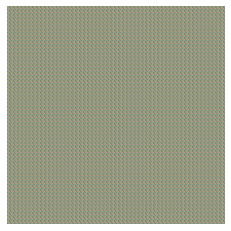

In [13]:
user.plot(reconstructed_user_data)

In [88]:
p_values = []
for i in range(gt_features.shape[1]):
    tmp_series = gt_features[:, i].cpu().numpy()
    tmp_series = (tmp_series - np.mean(tmp_series)) / np.std(tmp_series)
    p_values.append((np.std(tmp_series), stats.kstest(tmp_series, 'norm').pvalue)[1])
    
p_values = np.array(p_values)

In [89]:
np.argpartition(p_values, -5)[-5:]

array([ 33, 418, 439, 366, 315], dtype=int64)

1.5900917 0.0 KstestResult(statistic=0.9440929323026147, pvalue=1.5837936379083882e-50)


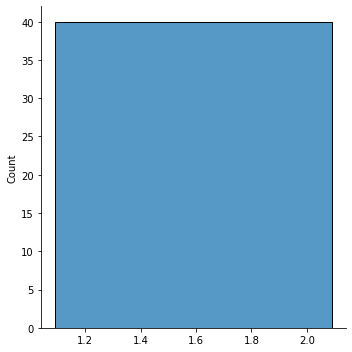

In [93]:
f_ind = 33
tmp_series = gt_features[:, f_ind].cpu().numpy()
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series), stats.kstest(tmp_series, 'norm'))

2.3396096 1.0542752


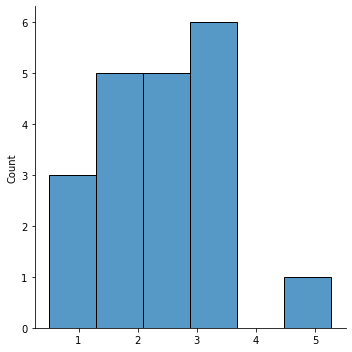

In [91]:
tmp_series = est_features[:, f_ind].cpu().numpy()
sns.displot(tmp_series)
print(np.mean(tmp_series), np.std(tmp_series))

In [ ]:
server.reset_model()
server.reconfigure_model('cls_attack', extra_info=extra_info)
with torch.no_grad():
    *_, l_w, l_b = server.model.parameters()
    l_w.copy_(l_w * 1)

In [ ]:
server.model.model.fc(torch.tensor(np.percentile(gt_features, 10, axis=0).astype(gt_features.dtype)))[0]

In [28]:
gt_features = torch.cat(gt_features)

In [33]:
est_features.shape

torch.Size([512, 20])

In [79]:
np.argmax(p_values)

315